In [3]:
from music21 import *

In [5]:
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [6]:
import os

#Array Processing
import numpy as np

#specify the path
path='midi_samples/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: midi_samples/schumm-1.mid
Loading Music File: midi_samples/schumm-2.mid
Loading Music File: midi_samples/schub_d960_4.mid
Loading Music File: midi_samples/schumm-3.mid
Loading Music File: midi_samples/schub_d960_1.mid
Loading Music File: midi_samples/schumm-6.mid
Loading Music File: midi_samples/schumm-4.mid
Loading Music File: midi_samples/schub_d960_2.mid
Loading Music File: midi_samples/schub_d960_3.mid
Loading Music File: midi_samples/schumm-5.mid
Loading Music File: midi_samples/schuim-4.mid
Loading Music File: midi_samples/schuim-1.mid
Loading Music File: midi_samples/schuim-3.mid
Loading Music File: midi_samples/schuim-2.mid
Loading Music File: midi_samples/schubert_D850_4.mid
Loading Music File: midi_samples/schubert_D935_4.mid
Loading Music File: midi_samples/schub_d760_4.mid
Loading Music File: midi_samples/schubert_D850_1.mid
Loading Music File: midi_samples/schubert_D935_1.mid
Loading Music File: midi_samples/schub_d760_1.mid
Loading Music File: midi_sam

In [54]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

308


(array([186.,  46.,  27.,  10.,   4.,   6.,   6.,  12.,   8.,   3.]),
 array([1.0000e+00, 1.7290e+02, 3.4480e+02, 5.1670e+02, 6.8860e+02,
        8.6050e+02, 1.0324e+03, 1.2043e+03, 1.3762e+03, 1.5481e+03,
        1.7200e+03]),
 <a list of 10 Patch objects>)

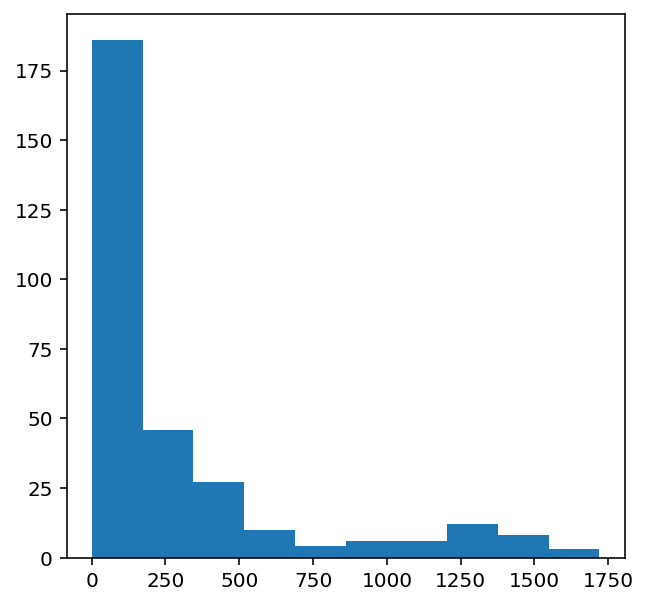

In [55]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [56]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

173


In [57]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [58]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [59]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [60]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [61]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           17300     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [62]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
503/503 [==============================] - 14s 27ms/step - loss: 4.5733 - val_loss: 4.0010

Epoch 00001: val_loss improved from inf to 4.00103, saving model to best_model.h5
Epoch 2/50
503/503 [==============================] - 12s 24ms/step - loss: 3.8010 - val_loss: 3.7844

Epoch 00002: val_loss improved from 4.00103 to 3.78439, saving model to best_model.h5
Epoch 3/50
503/503 [==============================] - 12s 24ms/step - loss: 3.6045 - val_loss: 3.6338

Epoch 00003: val_loss improved from 3.78439 to 3.63376, saving model to best_model.h5
Epoch 4/50
503/503 [==============================] - 12s 24ms/step - loss: 3.4581 - val_loss: 3.5200

Epoch 00004: val_loss improved from 3.63376 to 3.51998, saving model to best_model.h5
Epoch 5/50
503/503 [==============================] - 12s 25ms/step - loss: 3.3554 - val_loss: 3.4906

Epoch 00005: val_loss improved from 3.51998 to 3.49064, saving model to best_model.h5
Epoch 6/50
503/503 [==============================] - 13s 2

In [63]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

In [64]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(100):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[23, 30, 11, 11, 11, 11, 110, 40, 110, 11, 40, 40, 40, 40, 40, 40, 110, 11, 11, 11, 11, 11, 11, 11, 11, 110, 110, 110, 40, 110, 23, 23, 40, 11, 11, 11, 11, 40, 11, 11, 40, 11, 40, 40, 40, 40, 40, 40, 40, 109, 109, 109, 109, 109, 109, 109, 80, 40, 40, 40, 40, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]


In [65]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [66]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [67]:
convert_to_midi(predicted_notes)